In [1]:
import scraper_eod as s
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt
import time
from scipy.stats import norm
import seaborn as sns
from yahoo_fin import options
from yahoo_fin.stock_info import *
from yahoo_fin.stock_info import get_data, get_splits
import mibian
import time
m = s.StockMongo()
import indicator_daily as i

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


In [2]:
start_time = time.time()
op = m.get_options('GOOG')
print("--- %s seconds ---" % (time.time() - start_time))

--- 25.45940637588501 seconds ---


In [4]:
op = op[op['lastTradeDateTime']==op.index]

,ask,bid,change,changePercent,contractName,contractPeriod,contractSize,currency,daysBeforeExpiration,delta,...,openInterest,rho,strike,theoretical,theta,timeValue,type,updatedAt,vega,volume
date,,,,,,,,,,,,,,,,,,,,,
2022-05-09,971.5,954.0,-32.05,-0.0244,GOOG220520C01300000,MONTHLY,REGULAR,USD,10,0.9941,...,100.0,0.3874,1300,962.7500,-0.3997,0.0,CALL,2022-05-09,0.0662,16.0
2022-05-09,811.5,793.8,-337.61,-0.2924,GOOG220520C01460000,MONTHLY,REGULAR,USD,10,0.9932,...,11.0,0.4351,1460,802.6500,-0.3575,0.0,CALL,2022-05-09,0.0742,1.0
2022-05-09,377.0,359.0,3.51,0.008,GOOG220520C01900000,MONTHLY,REGULAR,USD,10,0.9445,...,6.0,0.5329,1900,368.0000,-1.3056,0.0,CALL,2022-05-09,0.4398,2.0
2022-05-09,339.0,321.6,-137.28,-0.2834,GOOG220520C01940000,MONTHLY,REGULAR,USD,10,0.9260,...,2.0,0.5316,1940,330.3000,-1.5879,0.0,CALL,2022-05-09,0.5501,1.0
2022-05-09,283.0,266.0,-50.60,-0.1446,GOOG220520C02000000,MONTHLY,REGULAR,USD,10,0.8917,...,22.0,0.5250,2000,274.5000,-1.9871,0.0,CALL,2022-05-09,0.7303,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,789.5,770.5,37.17,0.0516,GOOG240119P02900000,MONTHLY,REGULAR,USD,608,-0.7917,...,14.0,-34.0840,2900,780.0006,-0.1516,0.0,PUT,2022-05-20,8.1006,1.0
2022-05-20,831.0,812.0,28.32,0.0368,GOOG240119P02950000,MONTHLY,REGULAR,USD,608,-0.8118,...,4.0,-34.9451,2950,821.5007,-0.1409,0.0,PUT,2022-05-20,7.6196,1.0
2022-05-20,873.0,854.0,43.16,0.0517,GOOG240119P03000000,MONTHLY,REGULAR,USD,608,-0.8314,...,238.0,-35.7447,3000,863.5000,-0.1296,0.0,PUT,2022-05-20,7.1075,1.0


In [3]:
op.head()

,ask,bid,change,changePercent,contractName,contractPeriod,contractSize,currency,daysBeforeExpiration,delta,...,openInterest,rho,strike,theoretical,theta,timeValue,type,updatedAt,vega,volume
date,,,,,,,,,,,,,,,,,,,,,
2022-05-09,1071.5,1054.0,0.00,NaN,GOOG220520C01200000,MONTHLY,REGULAR,USD,10,0.9947,...,1.0,0.3577,1200,1062.75,-0.4062,0.0,CALL,2022-05-09,0.0594,NaN
2022-05-09,971.5,954.0,-32.05,-0.0244,GOOG220520C01300000,MONTHLY,REGULAR,USD,10,0.9941,...,100.0,0.3874,1300,962.75,-0.3997,0.0,CALL,2022-05-09,0.0662,16.0
2022-05-09,951.5,934.0,19.12,0.0152,GOOG220520C01320000,MONTHLY,REGULAR,USD,10,0.9939,...,38.0,0.3933,1320,942.75,-0.3983,0.0,CALL,2022-05-09,0.0677,1.0
2022-05-09,931.5,913.7,-133.67,-0.1077,GOOG220520C01340000,MONTHLY,REGULAR,USD,10,0.9945,...,46.0,0.3998,1340,922.60,-0.3505,0.0,CALL,2022-05-09,0.0622,1.0
2022-05-09,911.5,893.7,-257.42,-0.1701,GOOG220520C01360000,MONTHLY,REGULAR,USD,10,0.9943,...,23.0,0.4057,1360,902.60,-0.3492,0.0,CALL,2022-05-09,0.0636,6.0


In [2]:
symbols = m.get_symbols()
tickers = []
for sym in symbols:
    tickers.append(sym['sym'])

In [18]:
o = i.Options('BBBY')
o.options

C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


,date,contractName,contractSize,contractPeriod,currency,type,inTheMoney,lastTradeDateTime,expirationDate,strike,...,rho,theoretical,intrinsicValue,timeValue,updatedAt,daysBeforeExpiration,iv,close,volatility,vix
0,2022-07-15,BBBY220722C00001000,REGULAR,WEEKLY,USD,CALL,TRUE,2022-07-07,2022-07-22,1,...,0.0002,4.050,0,0,2022-07-16,5,147.8297,4.96,1.389187,24.23
1,2022-07-15,BBBY220722C00002000,REGULAR,WEEKLY,USD,CALL,TRUE,2022-07-05,2022-07-22,2,...,0.0003,3.000,0,0,2022-07-16,5,147.8297,4.96,1.389187,24.23
2,2022-07-15,BBBY220722C00003000,REGULAR,WEEKLY,USD,CALL,TRUE,2022-07-13,2022-07-22,3,...,0.0005,2.060,0,0,2022-07-16,5,147.8297,4.96,1.389187,24.23
3,2022-07-15,BBBY220722C00004000,REGULAR,WEEKLY,USD,CALL,TRUE,2022-07-13,2022-07-22,4,...,0.0007,1.000,0,0,2022-07-16,5,147.8297,4.96,1.389187,24.23
4,2022-07-15,BBBY220722C00005000,REGULAR,WEEKLY,USD,CALL,FALSE,2022-07-13,2022-07-22,5,...,0.0004,0.280,0,0,2022-07-16,5,147.8297,4.96,1.389187,24.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,2022-07-15,BBBY240119P00035000,REGULAR,MONTHLY,USD,PUT,TRUE,2022-04-29,2024-01-19,35,...,-0.1652,30.775,0,0,2022-07-16,551,149.9377,4.96,1.389187,24.23
410,2022-07-15,BBBY240119P00037000,REGULAR,MONTHLY,USD,PUT,TRUE,2022-02-08,2024-01-19,37,...,-0.1619,32.725,0,0,2022-07-16,551,149.9377,4.96,1.389187,24.23
411,2022-07-15,BBBY240119P00040000,REGULAR,MONTHLY,USD,PUT,TRUE,2022-06-29,2024-01-19,40,...,-0.1615,35.500,0,0,2022-07-16,551,149.9377,4.96,1.389187,24.23
412,2022-07-15,BBBY240119P00042000,REGULAR,MONTHLY,USD,PUT,TRUE,2022-06-29,2024-01-19,42,...,-0.1419,37.450,0,0,2022-07-16,551,149.9377,4.96,1.389187,24.23


<AxesSubplot:xlabel='rel_risk', ylabel='r'>

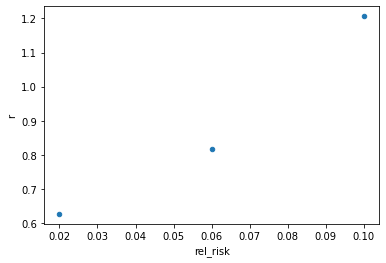

In [19]:
s = o.returns
#s[s.is_won].plot.scatter(x='probability', y='return')
#s.plot.scatter(x='rel_risk', y='return')
s[(s['rel_risk']>0)&(s['rel_risk']<3)&(s['r']>0)&(s['r']<2)].plot.scatter(x='rel_risk', y='r')
#o.strikeDates[0].volRange

In [5]:
s['']

Index(['rel_risk', 'high_put', 'low_call', 'p', 'r'], dtype='object')

In [10]:
o.formula

{'_id': ObjectId('62cbc770023263c9811de5d8'),
 'y0': 1.0421922361073332,
 'sqr_rel_risk': 0.05456563711196855,
 'probability': -0.05151829485920184,
 'iv': -0.011392088373822933,
 'vix': 0.0037675805433702177,
 'days_to_strike': -0.0033249175772761138,
 'ticker': 'ABT',
 'date': datetime.datetime(2022, 7, 11, 0, 0)}

In [67]:
linear_regressor = LinearRegression()
selection = s[(s['rel_risk']>0)&(s['rel_risk']<3)&(s['return']>0)&(s['return']<2)]
selection['sqr_rel_risk'] = np.log(selection['rel_risk'])
y = selection['return']
x = selection[['sqr_rel_risk', 'probability', 'iv', 'vix', 'days_to_strike']]
linear_regressor.fit(x, y)

C:\Users\ander\AppData\Local\Temp/ipykernel_23856/797529396.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selection['sqr_rel_risk'] = np.log(selection['rel_risk'])


LinearRegression()

In [68]:
linear_regressor.intercept_

-0.05937126920084923

In [69]:
linear_regressor.coef_

array([-0.17392879, -0.11652442, -0.01080193,  0.01907724,  0.00053581])